In [23]:
import warnings
warnings.filterwarnings('ignore')

In [24]:
#%matplotlib notebook
import colorsys
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats as stats
import matplotlib.pyplot as plt
from nettools.monoplex import NetworkGenerator 
from nettools.multiplex import MultiplexConstructor
from nettools.multiplex import InterMeasures
from nettools.monoplex import CentralityMeasure
from nettools.epidemic import SISMultiplex, SIRMultiplex
from nettools.utils import load_multinet_by_name, NX_CENTRALITY
from nettools.utils.ctest import spread_eff_centr_test

# Centrality for multiplex synthetic networks
In this notebook I describe centrality measure for *monoplex* and *multiplex* synthetic networks, besides that I will spread disease on each tested network, using seed nodes with greatest centrality score, results will be noted and ploted. My aim is to find best seed node for multiplex networks.<br><br>
In my forth experiment I will use different approach. I will use different spreading rate for each network, but spreading between networks (eg. BA) will stay the same.

### Reasearch approach
In my reaserch I will test centrality on:
* Aggregated networks
* Weighted Aggregated networks
* Mulitplex Measures

### Synthetic networks used in reaserch
In my work I will use five synthetic networks: 
* **ER-ER** Network
* **ER-BA** Network
* **BA-BB** Network
* **BA-BA** Not correlated Network
* **BA-BA** Correlated Network

# Reaserch enviroment
<img src="../images/settings_logo.jpg", width=400, height=400></img>

In this experiment real word network will be loaded. This network will be used for same test as ealier. <br><br>
Four different scenarios: 
* Same spreading rates *[Experiment 1]*
* Diffrent spreading rates *[Experiment 2]*
* Higher spreading rate between layers *[Experiment 3]*
* Higher intralayer spreading *[Experiment 4]*

** Load network and define interconnection measure object **

In [25]:
# London
network_london = load_multinet_by_name('london')
im_london = InterMeasures(network=network_london)
# FAO
network_fao = load_multinet_by_name('fao')
im_fao = InterMeasures(network=network_fao)
# EU Airlines
network_eu = load_multinet_by_name('EUAir')
im_eu = InterMeasures(network=network_eu)

Layers description: 

**London**

In [26]:
pd.DataFrame(network_london.layers_attr.items(), columns=['id', 'name'])

,id,name
0,1,Tube (All underground lines aggregated)
1,2,Overground
2,3,DLR


**FAO** (first 4 records)

In [27]:
pd.DataFrame(network_fao.layers_attr.items()[:4], columns=['id', 'name'])

,id,name
0,1,"Beverages,_non_alcoholic"
1,2,Cream_fresh
2,3,Food_prep_nes
3,4,"Cheese,_whole_cow_milk"


**EU Airlines** (first 4 records)

In [28]:
pd.DataFrame(network_eu.layers_attr.items()[:4], columns=['id', 'name'])

,id,name
0,1,Lufthansa
1,2,Ryanair
2,3,Easyjet
3,4,British_Airways


# Multiplex Networks
<img src="../images/multi.png", width=400, height=400></img>

## 1. Centrality for aggregated network
In second step network centrality will be examined using aggregated networks. 

In [29]:
agg_net_london = im_london.agg_net
agg_net_fao = im_fao.agg_net
agg_net_eu = im_eu.agg_net

## 1.4 Experiment:
In forth experiment I want to find what is main reason for getting centrality worst for multilayer networks. To test that I will use different spreading rates on each network, but spreading across layrs will stay the same.<br>
In second experiment I will set different spreading rates for each layer.
<br>
$$ \beta_A = 0.1 $$ <br> $$ \beta_{AB} = 0.1 $$ <br> $$ \beta_B = 0.1 $$ <br> $$\beta_{AB} = 0.1$$

In [30]:
beta_param = {0: {0: 0.1, 1: 0.1, 2: 0.1}, 1: {0: 0.1, 1: 0.1, 2: 0.1}, 2: {0: 0.1, 1: 0.1, 2: 0.1}}
rec_param = {0: {0: 1.0, 1: 1.0, 2: 1.0}, 1: {0: 1.0, 1: 1.0, 2: 1.0}, 2: {0: 1.0, 1: 1.0, 2: 1.0}}

### 1.1.1 London Network
Centrality score for each node is computed, in next step this score will be used to begin epidemy.

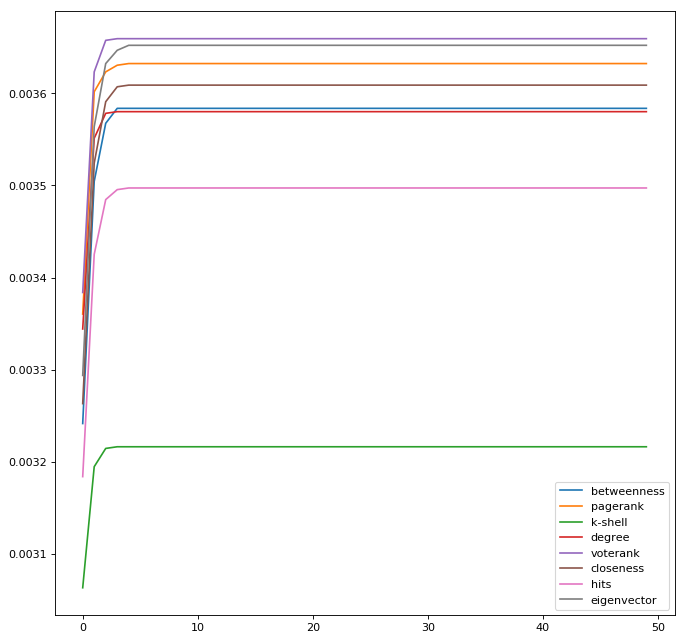

In [31]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
for idx, method in enumerate(NX_CENTRALITY.keys()):
    if method == "supernode":
        continue
    avg_results = np.zeros((500, 50))
    for n_time in range(0, 500):
        cn = CentralityMeasure(agg_net_london)
        results_cn = cn.network_cn(method)
        if method == 'hits':
            results_cn = results_cn[1]
        best_nodes = sorted(results_cn.items(), key=lambda x: x[1])[::-1]
        sir = SIRMultiplex(network_london, beta=beta_param, mu=rec_param, seed_nodes=[best_nodes[0][0]])
        result_sir = sir.run(epochs=50)
        avg_results[n_time] = np.array(result_sir)
    plt.plot(np.mean(avg_results, axis=0) / float(network_london.network.shape[0] * network_london.network.shape[2]), 
             hold=True, label=method)
plt.legend()
plt.show(True)

In [32]:
cent_dict = {}
cent_val = {}
cent_dict_15 = {}
cm_london = CentralityMeasure(agg_net_london)
for method in NX_CENTRALITY.keys():
    if method == 'supernode':
        continue
    results = cm_london.network_cn(method)
    if method == 'hits':
        results = results[1]
    best_nodes = sorted(results.items(), key=lambda x: x[1])[::-1]
    cent_val[method] = sorted(results.values())[::-1]
    cent_dict[method] = [cnt[0] for cnt in best_nodes]
    cent_dict_15[method] = [cnt[0] for cnt in best_nodes[:15]]

In [33]:
scores = {}
scores_15 = {}
mean_realisation = 500
for method, nodes in cent_dict.items():
    node_labels = []
    nodes_scores = []
    for node in nodes:
        mean_spread = []
        for _ in range(mean_realisation):
            sis = SIRMultiplex(network_london, beta=beta_param, mu=rec_param, seed_nodes=[node])
            sis.run(epochs=10, visualize=False)
            mean_spread.append(sis.get_num('i') + sis.get_num('r'))
        node_labels.append(node)
        nodes_scores.append(np.mean(mean_spread))
    scores[method] = node_labels, nodes_scores
    scores_15[method] = nodes_scores[:15]
pd.DataFrame.from_dict(scores_15)

,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,3.904,3.950,4.020,4.040,3.930,3.594,3.984,4.016
1,3.910,3.728,3.998,3.990,3.894,3.506,3.924,4.054
2,3.946,3.682,4.006,3.766,3.606,3.502,4.028,3.994
3,3.898,4.016,4.038,3.698,3.736,3.562,3.790,3.960
4,4.076,4.034,3.764,3.604,3.678,3.296,3.822,3.836
5,3.778,3.956,3.994,3.582,3.606,3.244,3.786,4.012
6,3.990,3.924,4.014,4.062,3.972,3.212,3.796,3.756
7,3.704,3.976,3.794,3.576,3.566,3.552,3.966,3.792
8,3.696,3.760,3.866,3.962,3.878,3.296,3.880,3.882
9,3.668,3.584,4.136,3.462,3.500,3.252,3.962,4.064


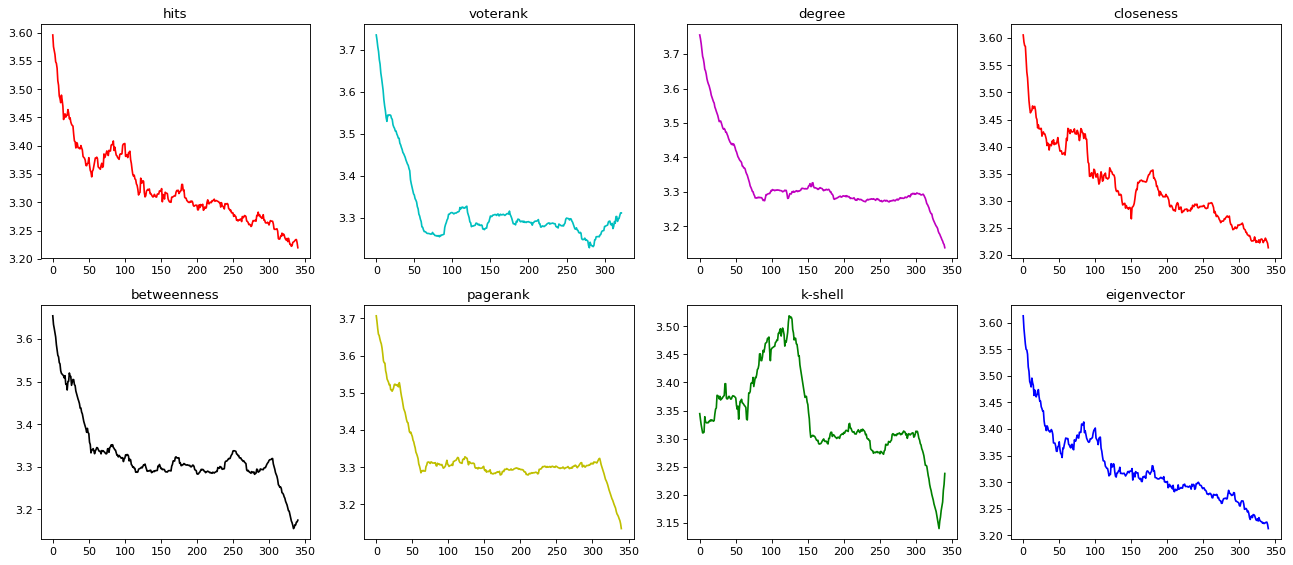

In [34]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
colors = "bgrcmrkygbb"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    sp = plt.subplot(840 + idx_counter)
    sp.plot(running_mean(nd_lab_scores[1], 30), colors[idx_counter + 1])
    sp.set_title(method)
    idx_counter += 1
plt.show()

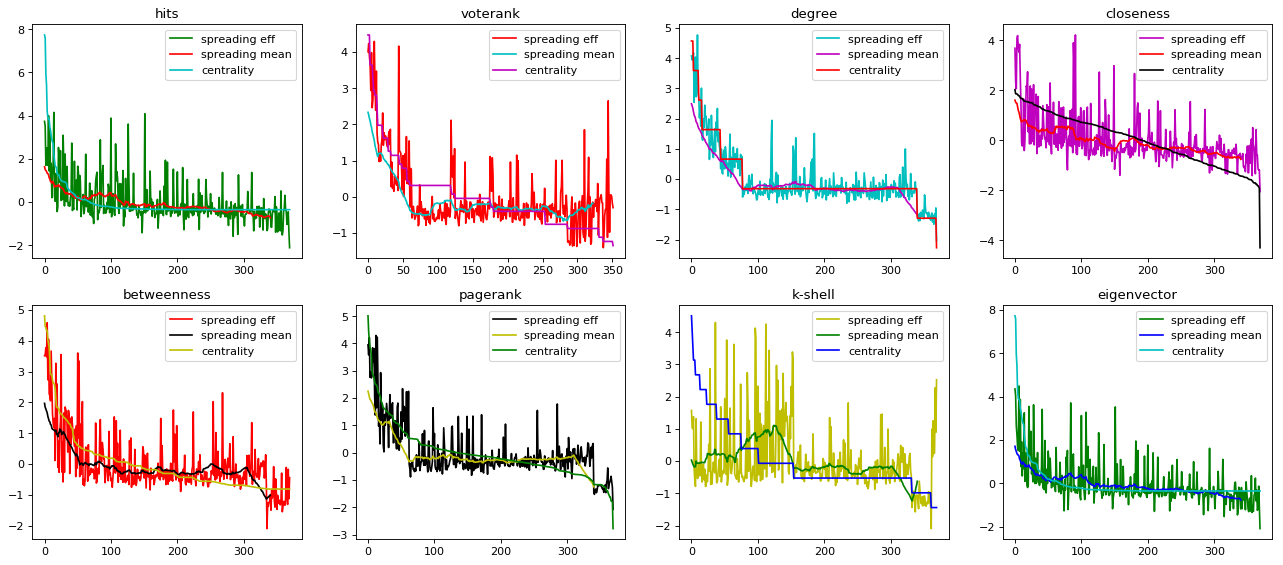

Kendal Correlation


,betweenness,closeness,degree,eigenvector,hits,k-shell,pagerank,voterank
0,0.348619,0.418243,0.667245,0.416259,0.376542,0.213774,0.304317,0.268232


In [35]:
def running_mean(x, nnodes):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[nnodes:] - cumsum[:-nnodes]) / nnodes

idx_counter = 1
corr_kendal = {}
colors = "bgrcmrkygbcmgrc"
fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplots_adjust(top=1.5)
for method, nd_lab_scores in scores.items():
    normalized_spread = (np.array(nd_lab_scores[1]) - np.mean(nd_lab_scores[1])) / np.std(nd_lab_scores[1])
    normalized_cent = (cent_val[method] - np.mean(cent_val[method])) / np.std(cent_val[method])
    sp = plt.subplot(840 + idx_counter)
    sp.plot(normalized_spread, colors[idx_counter], label="spreading eff")
    sp.plot(running_mean(normalized_spread, 30), colors[idx_counter + 1], label="spreading mean")
    sp.plot(normalized_cent, colors[idx_counter + 2], label="centrality")
    sp.legend()
    tau, p_value = stats.kendalltau(
                    nd_lab_scores[1],
                    cent_val[method]
                )
    corr_kendal[method] = [tau]
    sp.set_title(method)
    idx_counter += 1
plt.show()
print("Kendal Correlation")
pd.DataFrame.from_dict(corr_kendal)

In [36]:
%%capture
print("Network generated and constructed!")
test_props = {'mean_num': 1500, "epochs": 35, "beta": beta_param, "mu": rec_param}
print("Start process...")
spread_val, cent_scores, results_names = spread_eff_centr_test(network_london, test_properties=test_props)

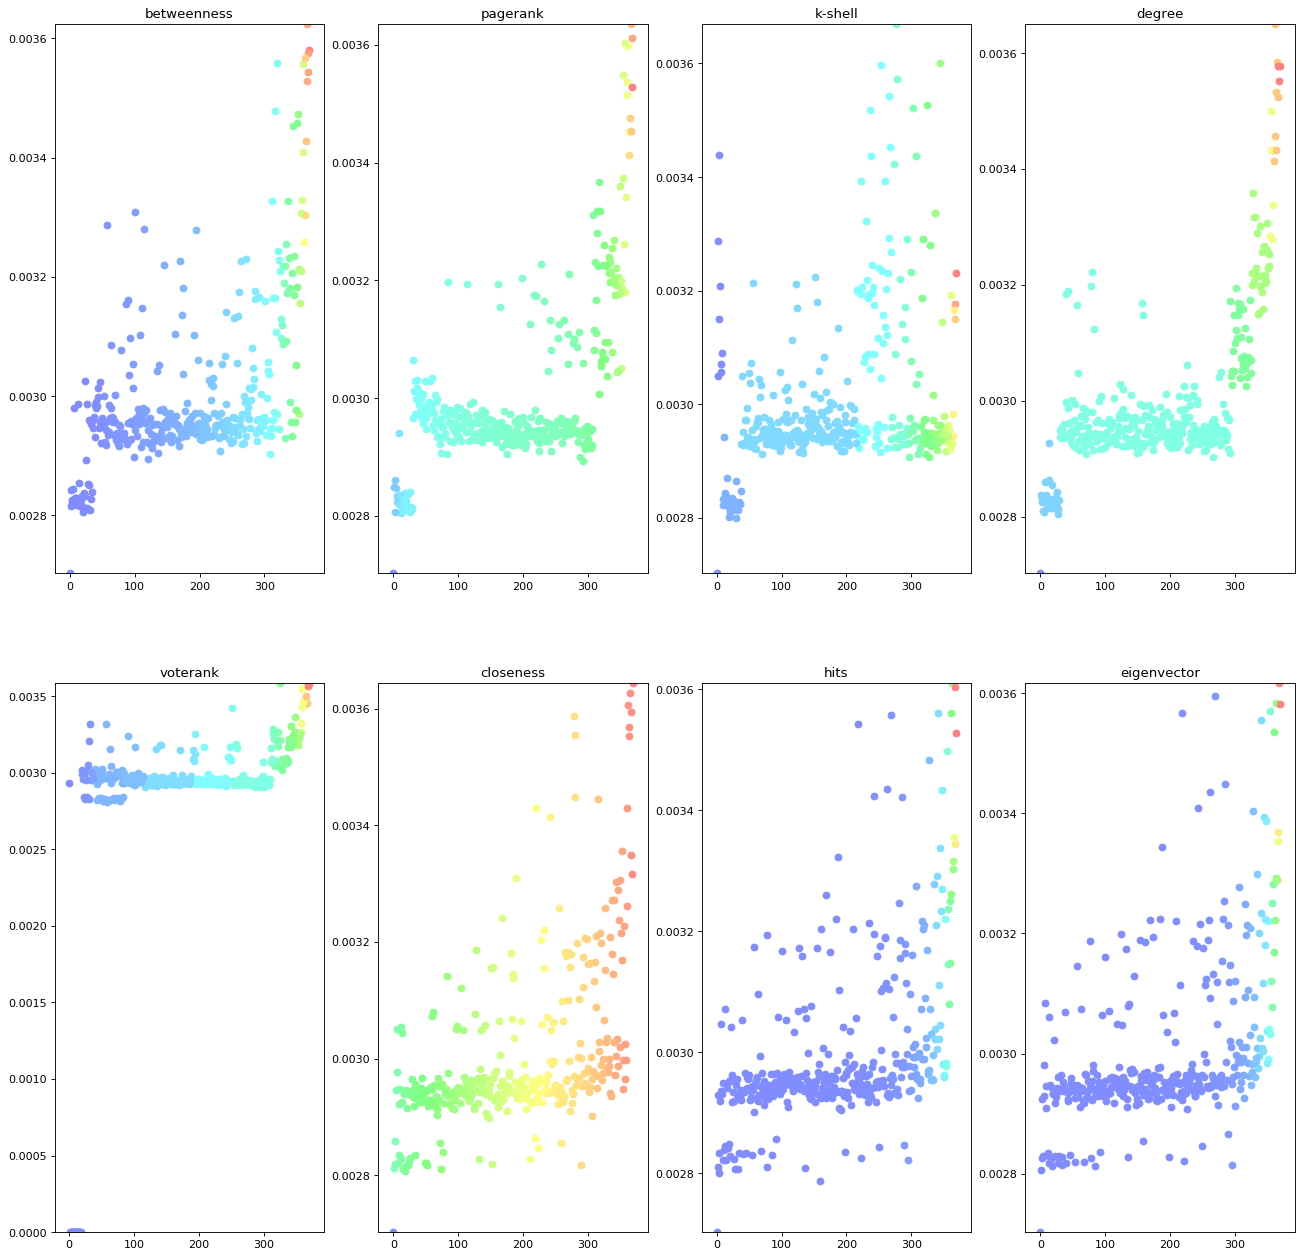

In [38]:
fig = plt.figure(figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for method_idx in range(1, spread_val.shape[0]):
    method_scores_spread = spread_val[method_idx]
    method_scores_cent = cent_scores[method_idx]
    method_scores_cent = method_scores_cent - np.min(method_scores_cent)
    method_scores_cent = 0.65 * (method_scores_cent / np.max(method_scores_cent))
    # Find data ranks
    temp_sort = np.argsort(method_scores_cent)
    data_centrality_rank = np.empty(len(method_scores_cent), int)
    data_centrality_rank[temp_sort] = np.arange(len(method_scores_cent))
    sp = plt.subplot(240 + method_idx)
    for node_id in range(network_london.network.shape[0]):
        color_rgb = colorsys.hsv_to_rgb(0.65 - method_scores_cent[node_id], 0.5, 1.0)
        sp.scatter(data_centrality_rank[node_id], method_scores_spread[node_id],
                   c=(color_rgb[0], color_rgb[1], color_rgb[2], 1))
    sp.set_title(results_names[method_idx - 1])
    sp.set_ylim([np.min(method_scores_spread), np.max(method_scores_spread)])
plt.show(True)